In [2]:
import numpy as np
import pandas as pd
from collections import Counter 
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt 

In [3]:
# View Setting
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

### 0. Data Processing

In [4]:
class Data():    
    def __init__(self, source_dir="./Train_data.csv", mode='Train'):
        self.mode=mode
        self.src_data = pd.read_csv(source_dir, index_col=0) 
        
        if self.mode=='Train':
            # class to numeric; pos: 1, neg: 0
            self.src_data['class'] = self.src_data['class'].replace('neg', 0)
            self.src_data['class'] = self.src_data['class'].replace('pos', 1)
        elif self.mode=='Test': pass
        else: 
            print("\nSelect mode between 'Train / Test'")
            return -1
        
        # na, numeric processing
        self.src_data = self.src_data.replace('na', np.nan) # change 'na' ro np.nan
        self.src_data = self.src_data.apply(pd.to_numeric) # change object to int or float

        #fix col name
        self.src_data.rename(columns = {'am_0': 'am_000'}, inplace = True)
        
        if self.mode=='Train':
            self.X, self.y = self.src_data.iloc[:, 1:], self.src_data["class"]
            
        elif self.mode=='Test':
            self.X, self.y = self.src_data, None
        print(f'Finished loading {source_dir.split("/")[-1]}')
                
        
    def processNA(self, dropped=None, pos_median=None, total_median=None):
        if self.mode=='Train':
            # check null columns per cats
            pos_data = self.src_data[self.src_data["class"]==1] 
            neg_data = self.src_data[self.src_data["class"]==0] 

            pos_df, neg_df = pos_data.isnull().sum().to_frame(name="pos_null_cnt"), neg_data.isnull().sum().to_frame(name="neg_null_cnt")
            null_check = pos_df.join(neg_df)
            null_check["total_null"] = null_check["pos_null_cnt"] + null_check["neg_null_cnt"]
            null_check.insert(1, "pos_cnt", len(pos_data))
            null_check.insert(3, "neg_cnt", len(neg_data))

            null_check["pos_null_ratio"] = null_check.pos_null_cnt/null_check.pos_cnt
            null_check["neg_null_ratio"] = null_check.neg_null_cnt/null_check.neg_cnt
            null_check["total_null_ratio"] = (null_check.pos_null_cnt + null_check.neg_null_cnt)/len(self.src_data)

            # drop cols w/ too many na's
            dropped = null_check[null_check.total_null_ratio>=0.4]
            dropped = set(dropped.index)
            self.src_data.drop(dropped, inplace=True, axis=1)

            # na replacement
            with_pos = null_check[null_check.pos_null_ratio>=0.3]
            with_pos = set(with_pos.index) - dropped
            self.POS_MEDIAN = self.src_data[with_pos].median(axis=0).to_dict()

            with_total = null_check[null_check.pos_null_ratio<0.3]
            with_total = set(with_total.index) - dropped
            self.TOTAL_MEDIAN = self.src_data[with_total].median(axis=0).to_dict()
        
        elif self.mode=="Test":
            if dropped is None or pos_median is None or total_median is None:
                print("\n:::ERROR:::kawrgs cannot be None in the Test mode")
                return -2
            else:
                # drop cols w/ too many na's
                self.src_data.drop(dropped, inplace=True, axis=1)
                
                # na replacement
                self.POS_MEDIAN = pos_median
                self.TOTAL_MEDIAN = total_median
            
        self.src_data.fillna(value=self.POS_MEDIAN, inplace=True)
        self.src_data.fillna(value=self.TOTAL_MEDIAN, inplace=True)
        
        print(f"Dropped {len(dropped)} columns: {','.join(dropped)}")
        print(f"Replaced with POS_MEDIAN and TOTAL_MEDIAN")
        
        if self.mode=="Train": self.X = self.src_data.iloc[:, 1:]
        else: self.X = self.src_data
            
        return dropped, self.POS_MEDIAN, self.TOTAL_MEDIAN
    
    def replaceHisto(self):
        #histogram replacement
        prefixes = Counter([col.split("_")[0] for col in self.src_data.columns])
        histo_cols = dict()
        for pre, cnt in prefixes.items():
            if cnt>1:
                histo_cols[pre] = [pre+"_"+str(format(num, '03d')) for num in range(cnt)]
                
        for prefix, cols in histo_cols.items():
            self.src_data[prefix+"_median"] = self.src_data[cols].median(axis=1)
            self.src_data[prefix+"_mean"] = self.src_data[cols].mean(axis=1)
            self.src_data[prefix+"_var"] = self.src_data[cols].var(axis=1)
            self.src_data.drop(cols, inplace=True, axis=1)
            
        if self.mode=="Train": self.X = self.src_data.iloc[:, 1:]
        else: self.X = self.src_data
            
        print(f"Changed historgram cols to mean, median, variation")        
        
    def standardize(self, scaler = None):
        if self.mode=='Train': 
            scaler = StandardScaler()
            scaler.fit(self.X)
        else: 
            if scaler is None: 
                print("\n:::ERROR:::scaler cannot be None in the Test mode")
                return -3
            scaler = scaler
            
        scaled_X = scaler.transform(self.X) 
        scaled_X = pd.DataFrame(scaled_X, columns=self.X.columns, index=self.X.index)
        self.X = scaled_X
        
        print(f"Standardization finished")
        print(self.X.describe().applymap("{0:.2f}".format))
        return scaler
    
    def classBalancing(self, rndn_state=42):
        print('Original dataset shape: %s' % Counter(self.y))
        
        sm = SMOTE(random_state=rndn_state)
        X_res, y_res = sm.fit_resample(self.X, self.y)
        print('Resampled dataset shape: %s' % Counter(y_res))
        
        scaler = StandardScaler()
        scaled_X_res = scaler.fit_transform(X_res)
        scaled_X_res = pd.DataFrame(scaled_X_res, columns=X_res.columns, index=X_res.index)
        
        print(scaled_X_res.describe())
        self.X, self.y = scaled_X_res, y_res
        print('Oversampling finished')
        
    def featureSelection(self, isFitted=False, to_drop=None):
        # if already fitted, input columns to drop at to_drop pamam
        if not isFitted:
            forest = ExtraTreesClassifier(max_depth=6, 
                                          min_samples_leaf=3,
                                          min_samples_split=10,
                                          n_estimators=100, random_state=42)
            forest.fit(self.X, self.y)
            feature_importances = forest.feature_importances_

            #변수중요도 barplot
            ft_importances = pd.Series(feature_importances, index = self.X.columns)
            ft_importances = ft_importances.sort_values(ascending = False)
            
            plt.figure(figsize = (100,100))
            plt.title("Feature Importance")
            plt.barh(ft_importances.index, ft_importances.values)           
            
#             for x,y in zip(ft_importances.index, ft_importances.values):
#                 label = "{:.4f}".format(y)

#                 plt.annotate(label, # this is the text
#                              (x,y), # this is the point to label
#                              textcoords="offset points", # how to position the text
#                              xytext=(0,3), # distance from text to points (x,y)
#                              ha='center') # horizontal alignment can be left, right or center
            plt.show()
            
            # 제거할 feature 선택
            THRESHOLD = 0.0001
            to_drop = ft_importances[ft_importances<=THRESHOLD].index

        else: 
            if to_drop is None: 
                print("\n:::ERROR:::to_drop cannot be None if fitted")
                return -5
        
        self.X.drop(columns = to_drop, inplace=True, axis=1)
        print(f"Dropped feature: {', '.join(to_drop)}")

        return to_drop
        
        
    def dimReduction(self, pca_fitted = None):
        if self.mode=='Train': 
            pca = PCA()
            pca.fit(self.X)

            cumsum_ex_var = np.cumsum(pca.explained_variance_ratio_)
            dim = np.argmax(cumsum_ex_var >= 0.95) + 1
            print("number of dimensions: " + str(dim))
            
            plt.figure(figsize=(5, 5))
            plt.xlabel('Number of components')
            plt.ylabel('cumulative sum of explained variance')
            plt.plot(range(1, cumsum_ex_var.shape[0] + 1), cumsum_ex_var)
            
            pca = PCA(n_components=dim) # 
            pca.fit(self.X)
            
            print("explained variance ratio: " + str(sum(pca.explained_variance_ratio_)))
        
        else : 
            if pca_fitted is None:
                print("\n:::ERROR:::pca cannot be None in the Test mode\n")
                return -4
            pca = pca_fitted
        
        X_reduced = pca.transform(self.X)
        self.X = pd.DataFrame(X_reduced)
        print('PCA finished')
        return pca

Finished loading Train_data.csv
Dropped 9 columns: bo_000,bn_000,cr_000,bl_000,ab_000,br_000,bq_000,bm_000,bp_000
Replaced with POS_MEDIAN and TOTAL_MEDIAN
Changed historgram cols to mean, median, variation
Standardization finished
         aa_000    ac_000    ad_000    ae_000    af_000    ah_000    ai_000  \
count  57000.00  57000.00  57000.00  57000.00  57000.00  57000.00  57000.00   
mean       0.00     -0.00      0.00      0.00     -0.00      0.00     -0.00   
std        1.00      1.00      1.00      1.00      1.00      1.00      1.00   
min       -0.26     -0.43     -0.00     -0.04     -0.05     -0.43     -0.05   
25%       -0.26     -0.43     -0.00     -0.04     -0.05     -0.42     -0.05   
50%       -0.13     -0.43     -0.00     -0.04     -0.05     -0.19     -0.05   
75%       -0.05     -0.43     -0.00     -0.04     -0.05     -0.06     -0.05   
max      183.89      2.31    238.74    127.76     97.00     15.90     95.71   

         aj_000    ak_000    al_000    am_000    an_000 

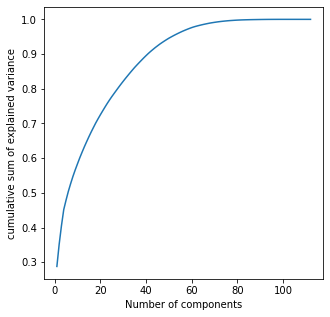

In [5]:
#train_data Processing
train_data = Data("Train_data.csv", mode="Train") # mode: Train / Test
dropped, POS_MEDIAN, TOTAL_MEDIAN = train_data.processNA() # na 많은 칼럼 drop, na값 대체
train_data.replaceHisto() # 히스토그램 대표값 대체
train_scaler = train_data.standardize() # 정규화 - !!!classBalancing 함수 이전 실행 필수_SMOTE 이전 정규화 필요하기 때문!!!
train_data.classBalancing() # SMOTE 사용한 class balancing
pca = train_data.dimReduction() # PCA 사용 차원 축소

X, y = train_data.X, train_data.y

In [6]:
data = pd.concat([y, X],1)
data.head(10)

,class,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
0,0,-4.048339,0.400815,0.365657,0.196540,-0.007132,0.097846,0.010249,0.257067,0.257509,-0.039746,0.019701,-0.345206,-0.458010,-0.011271,0.008089,-0.045482,0.063236,-0.054955,-0.114254,-0.088320,-0.003065,-0.016712,0.028935,-0.038196,0.009682,0.002120,0.045286,-0.088402,0.026804,-0.242384,-0.127444,0.198997,-0.271149,-0.161615,0.030960,-0.065630,-0.047908,0.129052,0.005233,-0.270314,-0.074828,0.148480,-0.055681,0.066482,-0.070558,-0.094404,-0.025013,0.047757,0.003730,0.076631,-0.052768,0.066235
1,0,-4.266923,0.343618,0.246503,0.342603,-0.006044,0.109070,0.070839,0.382369,0.514143,-0.021788,0.135387,-0.728136,-0.782590,-0.038105,-0.039137,0.008891,0.193835,-0.252412,-0.181518,-0.232435,0.019392,-0.007038,0.059317,0.293373,0.291648,0.019303,0.160246,-0.161625,0.021011,-0.407783,-0.189631,0.228726,-0.315390,-0.071027,-0.035863,-0.084910,-0.094815,0.307925,0.293931,-0.359694,0.037502,0.364715,0.085412,-0.004692,-0.154484,-0.030516,0.076249,-0.051639,-0.019394,0.044165,0.012269,-0.031977
2,0,-2.103832,1.095686,0.043888,-0.567270,-0.009079,-0.045918,0.305574,-0.360788,-0.414810,-0.087983,-0.038957,0.232351,0.525326,0.021729,0.000486,0.009583,0.127469,-0.220505,-0.007461,0.184725,-0.008135,-0.170826,0.079362,-0.356512,0.004385,0.027729,-0.004385,-0.018199,0.063742,-0.239698,0.083297,0.225377,-0.257302,0.175102,0.103321,0.074663,-0.018121,-0.129281,0.039098,-0.091193,-0.135166,-0.106706,-0.071901,0.086807,-0.082482,0.213517,0.170877,-0.002486,0.013341,-0.066891,0.073987,-0.036370
3,0,-4.587216,0.685265,0.299674,0.138042,-0.006342,-0.163413,0.000540,0.069811,0.244065,-0.048533,0.071597,-0.422019,-0.524039,0.012038,-0.020001,-0.001100,-0.009790,-0.047263,-0.112282,-0.090252,0.006205,-0.014189,0.044813,-0.088935,-0.101201,0.062782,0.046142,-0.064612,0.042356,-0.291208,-0.113352,0.095136,-0.343323,-0.154597,-0.226729,-0.100935,-0.115120,0.064378,-0.021936,-0.252487,0.020488,0.052442,0.075284,-0.023094,-0.185293,-0.127729,0.110342,-0.047431,-0.031595,0.063507,-0.011809,-0.003495
4,0,-4.777993,0.933467,0.330587,0.245607,-0.010618,-0.269161,0.187279,-0.206223,-0.405495,-0.160226,-0.505809,0.609632,0.687826,0.005577,0.058084,-0.051685,0.157678,0.151262,0.105898,-0.081118,-0.016745,0.035854,-0.083353,0.260554,0.268536,-0.020584,0.317642,-0.172601,0.031564,-0.483014,-0.128677,0.294328,-0.183416,-0.074057,0.342244,0.006470,0.044569,0.271694,0.331394,-0.134561,-0.018964,0.247233,-0.015945,0.042694,0.130031,-0.018138,-0.075665,0.102821,0.040293,0.002326,0.057454,-0.007452
5,0,-4.962144,1.109197,0.441368,0.227256,-0.015192,-0.380466,0.224313,-0.376335,-0.578961,-0.162454,-0.756929,0.800624,0.775754,-0.031487,0.190216,-0.210866,0.283122,0.294785,-0.178806,-0.278131,-0.032059,0.031428,0.005167,1.021801,0.299954,-0.286569,-0.865934,0.190771,-0.259637,1.785868,0.597491,-0.698912,1.336063,0.629643,-0.269437,0.229470,0.097955,-0.518780,-0.068792,0.451555,-0.049174,-0.266105,-0.034991,-0.108424,0.438293,0.054413,-0.259298,0.074250,0.005751,-0.142150,0.104291,-0.084873
6,0,-3.700948,0.076973,0.808521,-0.011530,-0.006714,-0.371391,0.151787,1.149880,0.335457,0.123829,-0.097155,-0.611533,-1.078394,-0.026554,-0.070568,-0.277718,0.101081,0.405478,-0.201119,-0.486899,-0.027494,0.043898,0.331071,1.120181,0.102963,-0.598717,-0.957335,0.238687,-0.348181,1.633120,0.844869,-0.710134,1.364568,0.382771,-0.053224,0.185673,0.363682,-0.542109,-0.583491,0.934682,-0.288163,-0.313438,-0.115461,-0.081360,0.114173,0.184706,-0.078044,0.074694,0.073251,0.242671,-0.114544,0.089152
7,0,-4.327955,0.340842,0.412997,0.311254,-0.010341,0.226190,-0.011052,0.665554,0.867250,0.038592,0.165737,-1.172232,-1.400383,-0.124449,0.006244,-0.160251,0.468755,-0.206918,-0.518785,-0.671793,0.031227,0.047834,0.143343,1.681157,0.868750,-0.352874,-0.855555,0.086404,-0.200575,1.656160,0.469414,-0.510271,1.260222,0.550985,-0.149700,0.111715,0.093010,-0.1

### 1. Train-Test Data Split

In [7]:
from sklearn.model_selection import train_test_split

#train-test data split
X_trainval, X_test, y_trainval, y_test = train_test_split(data, data["class"], test_size=0.2, random_state=44, stratify=data["class"])

#train-validation data split
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=33)

In [8]:
X_train = X_train.drop(['class'], axis=1)
X_val = X_val.drop(['class'], axis=1)
X_test = X_test.drop(['class'], axis=1)

In [9]:
print(sum(y_train==0))
print(sum(y_train==1))

35790
35805


### 2. Random Forest 모형

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [11]:
#랜덤포레스트 학습
rf = RandomForestClassifier(random_state = 222)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=222)

In [12]:
#정확도
rf_pred = rf.predict(X_val)
print('RandomForestClassifier 정확도 : {0:.4f}'.format(accuracy_score(y_val,rf_pred)))

RandomForestClassifier 정확도 : 0.9885


In [13]:
#Classification Report
print(classification_report(y_val, rf_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      8957
           1       0.98      1.00      0.99      8942

    accuracy                           0.99     17899
   macro avg       0.99      0.99      0.99     17899
weighted avg       0.99      0.99      0.99     17899



In [14]:
# 사이킷런의 정확도, 정밀도, 재현율, 오차행렬을 계산하는 API 호출
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# 호출한 지표들을 한꺼번에 계산하는 함수 정의
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도 : {:.4f}\n정밀도 : {:.4f}\n재현율 : {:.4f}'.format(accuracy, precision, recall))

get_clf_eval(y_val, rf_pred)

오차행렬
[[8781  176]
 [  29 8913]]
정확도 : 0.9885
정밀도 : 0.9806
재현율 : 0.9968


### 3. GridSearchCV (하이퍼파라미터 튜닝)

In [17]:
rf_param_grid = {
    'n_estimators': [100,200],
    'max_depth': [6,8,10],
    'min_samples_leaf': [3,5,7,9],
    'min_samples_split': [2,3,5,10]
}

In [18]:
rf_grid = GridSearchCV(rf, param_grid = rf_param_grid, scoring = "accuracy", n_jobs = -1, verbose = 1)
rf_gridsearch = rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [19]:
# 최적의 파라미터 찾기
print("Best average Accuracy : {0: .4f}".format(rf_gridsearch.best_score_))
print("Best parameters : ", rf_gridsearch.best_params_)

Best average Accuracy :  0.9640
Best parameters :  {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 200}


In [26]:
# 최적의 파라미터로 훈련
rf_best_para = rf_gridsearch.best_estimator_
rf_best_para.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=10,
                       n_estimators=200, random_state=222)

### 4. Confusion matrix, F1, Recall, Precision, Loss

In [15]:
# Accuracy Score
random_forest = RandomForestClassifier(random_state = 222)
random_forest.fit(X_train, y_train)

y_train_pred = random_forest.predict(X_train)
y_test_pred = random_forest.predict(X_test) 

print(accuracy_score(y_test,y_test_pred)) 

0.988692232055064


In [16]:
# Precision, Recall, F1 score
from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(y_test, y_test_pred))
print(recall_score(y_test, y_test_pred))
print(f1_score(y_test, y_test_pred))

0.9802354181307098
0.9974970948422276
0.9887909264099951


In [17]:
# Confusion Matrix(오차행렬)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_test_pred))

[[10962   225]
 [   28 11159]]


In [29]:
# 최적의 파라미터 
print(rf_grid.best_params_)

{'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 200}


In [18]:
# 마지막으로 총 Loss
## false positive * 10 + false negative * 500 (정비가 필요한데 필요하지 않다고 예측하면 500, 필요하지 않은데 필요하다고 예측하면 10)
print("Random Forest Final Loss : ", 223 * 10 + 29 * 500)

Random Forest Final Loss :  16730


### 5. Test data에 데이터전처리 적용

In [19]:
# Test data Processing
test_data = Data("./Test_data.csv", mode="Test")
src_data = test_data.src_data.copy()
test_data.processNA(dropped=dropped, pos_median=POS_MEDIAN, total_median=TOTAL_MEDIAN) #dropped, POS_MEDIAN, TOTAL_MEDIAN은 train data에서 fitting한 값
test_data.replaceHisto()
test_data.standardize(scaler=train_scaler) #scaler: train data에서 fitting한 값
test_data.dimReduction(pca_fitted=pca) #pca_fitted: train data에서 fitting한 값

test_X, test_y = test_data.X, test_data.y

Finished loading Test_data.csv
Dropped 9 columns: bo_000,bn_000,cr_000,bl_000,ab_000,br_000,bq_000,bm_000,bp_000
Replaced with POS_MEDIAN and TOTAL_MEDIAN
Changed historgram cols to mean, median, variation
Standardization finished
         aa_000    ac_000    ad_000    ae_000    af_000    ah_000    ai_000  \
count  19000.00  19000.00  19000.00  19000.00  19000.00  19000.00  19000.00   
mean      -0.00      0.00     -0.00     -0.01     -0.01     -0.01     -0.00   
std        1.47      1.00      0.00      0.57      0.80      0.97      0.82   
min       -0.26     -0.43     -0.00     -0.04     -0.05     -0.43     -0.05   
25%       -0.26     -0.43     -0.00     -0.04     -0.05     -0.42     -0.05   
50%       -0.13     -0.43     -0.00     -0.04     -0.05     -0.19     -0.05   
75%       -0.06     -0.43     -0.00     -0.04     -0.05     -0.06     -0.05   
max      183.89      2.31     -0.00     32.66     54.52     18.77     56.13   

         aj_000    ak_000    al_000    am_000    an_000  

In [20]:
test_X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
0,-2.540608,0.988281,-0.082748,0.002241,-0.008836,-0.762121,0.280105,-0.654628,-0.184806,0.971629,-0.306060,1.363724,0.557136,-1.668174,-0.294912,0.186095,0.022525,0.240388,0.112396,0.254373,2.871296,0.330737,0.265625,-0.235930,-0.156488,0.075966,0.259529,-0.066634,-0.004642,-0.260403,-0.087005,0.121251,-0.196104,-0.119283,-0.140351,-0.034562,-0.091094,-0.078302,0.040171,-0.002379,-0.012468,-0.067689,1.181666,2.069311,0.234375,-0.085069,-0.311958,0.174035,0.022230,-0.038507,-0.338351,-0.343891
1,-1.112538,0.407593,-0.013939,0.082308,-0.011666,0.146635,-0.018439,-0.442557,-0.463487,-0.150268,-0.231519,0.602010,0.799801,-0.024769,0.094224,-0.146935,0.088121,0.046273,-0.009188,0.073876,-0.025441,-0.013502,-0.146282,-0.253037,-0.217667,0.113044,0.050325,-0.062806,0.022460,-0.130047,-0.202493,0.067193,-0.258760,-0.097486,0.021592,0.072202,-0.043121,-0.059953,0.113142,-0.322455,-0.008778,0.074046,-0.118954,0.104593,0.049245,-0.003695,-0.239620,0.098189,0.000154,0.050531,-0.030284,0.031918
2,4.451232,-4.703421,-1.648598,3.683687,0.007499,-3.002807,-3.311702,0.246581,0.024758,0.108600,1.425774,0.069596,1.548022,-0.160748,-1.410736,-1.451052,1.348159,-2.651690,-1.980697,4.290788,-0.235297,-0.304708,-4.795360,1.268395,-1.380716,1.909406,1.235277,0.063690,1.132695,2.113421,-1.928351,0.000204,-0.154000,2.091821,1.615017,-1.294846,-2.825249,1.663611,-3.525993,0.030787,0.817465,0.779751,0.846645,-0.615521,0.188264,-1.376172,2.012293,1.372440,-0.106967,0.639329,-0.594388,0.195621
3,-2.482200,0.984128,-0.040576,0.049233,-0.008530,-0.580188,0.155456,-0.350232,-0.434134,-0.076664,-0.327731,0.669933,0.591984,0.124093,0.091145,0.007922,-0.020756,0.237521,0.126670,0.091032,-0.016317,-0.037882,0.007979,-0.238794,-0.116691,0.071950,0.203403,-0.058682,-0.006222,-0.347012,-0.058480,0.095131,-0.247097,-0.075005,-0.207346,-0.064650,-0.048202,-0.019033,0.047213,-0.121621,-0.024270,0.075006,0.013777,0.021402,0.183043,-0.017190,-0.076882,0.023835,0.019371,-0.023483,0.077614,-0.011217
4,0.312298,-1.226765,0.630195,0.433061,-0.010707,0.942930,-0.282277,1.136660,0.846602,0.029900,0.322684,-0.772647,-1.332216,-0.232353,0.209933,-0.322915,0.548129,-0.272350,-0.414949,-0.332465,0.012006,0.045986,-0.193469,0.726646,0.459170,-0.062072,-1.013309,0.115880,-0.112316,1.572146,0.324358,-0.520992,0.929887,0.637818,-0.183102,0.159347,-0.058685,-0.040341,0.073311,0.086864,0.265467,0.165586,-0.275610,0.109208,-0.287388,-0.021433,0.276131,0.142172,0.034696,0.447211,-0.241325,0.130170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18995,-2.213111,0.711802,-0.287417,0.187832,-0.007358,-0.193173,0.033387,-0.015166,0.012579,-0.085066,-0.041682,-0.022040,-0.100905,0.030572,-0.019297,0.008627,-0.118531,0.100945,-0.016890,-0.019658,-0.000604,-0.014187,0.044161,-0.179327,-0.163446,0.022083,0.118622,-0.057643,0.001197,-0.297430,-0.088308,0.112799,-0.301376,-0.209247,-0.194443,-0.099392,-0.029783,0.047074,-0.039087,-0.130229,-0.051329,0.060203,0.051827,-0.007373,0.036816,-0.015252,-0.035295,-0.032903,-0.004701,0.025269,0.038442,-0.010005
18996,4.618049,-2.451111,0.884291,0.243744,-0.020742,2.209751,-0.225529,1.005091,0.396018,-0.106685,0.489701,0.416213,0.576779,-0.329532,0.349821,-0.912507,0.509380,-0.293452,-0.548324,-0.159656,-0.006918,0.309206,-1.026781,0.841700,-0.006582,-0.304508,-1.215551,0.267151,-0.109867,2.668419,-0.092626,-0.573541,1.153272,0.513845,1.300136,0.552471,-0.275930,0.174371,0.027041,-0.521620,0.322600,0.373179,-0.199632,0.221135,-1.635277,-0.671470,0.801944,-0.579337,-0.178616,0.565984,-0.667603,0.396186
18997,-2.457547,0.992383,-0.066016,0.005186,-0.007737,-0.564181,0.137809,-0.264708,-0.371611,-0.157794,-0.316114,0.544427,0.467990,0.056815,0.033053,0.04

In [21]:
random_forest = RandomForestClassifier(random_state = 222)
random_forest.fit(X_train, y_train)

rf_real_pred = random_forest.predict(test_X) 

In [22]:
pred_class = []
for y in rf_real_pred:
    if y == 0:
        pred_class.append("0")
    else:
        pred_class.append("1")

In [23]:
Counter(pred_class)

Counter({'0': 13577, '1': 5423})

### 6. Test data csv에 저장

In [24]:
final_with_rf = pd.read_csv("Test_data.csv")

In [25]:
final_with_rf["pred_class"] = pred_class

In [26]:
final_with_rf.to_csv("머신러닝_1조.csv")